# Grad-CAMとAttentionによるモデルの判断根拠の可視化

In [1]:
import torch
torch.__version__

'1.13.0+cu116'

In [2]:
import os
os.getcwd()

'/working/my-fake-detect/fakeddit/fakeddit_python_file'

In [3]:
from IPython.display import display, HTML
from model import LanguageAndVisionConcatWithExtra
from dataset import FakeNewsDataset
from transformers import AdamW, get_linear_schedule_with_warmup
from utils import set_seed
from evaluate import evaluate

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
import torchvision
from torchvision import models, transforms
from PIL import Image
from PIL import ImageFile
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
#from transformers import BertTokenizer
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
#from transformers import BertModel
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import AdamW, get_linear_schedule_with_warmup
# XLnet
from transformers import XLNetTokenizer, XLNetModel
import random
import time
import os
import re
import math

# Grad-CAM
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
import cv2

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

In [4]:
model_name = "best_model.pt"

In [5]:
df_test = pd.read_csv("/working/my-fake-detect/fakeddit/fakeddit_split_dataset/RE_LARGE_extra_all_keys_2len_all_test.csv")
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: NVIDIA RTX A6000


In [6]:
df_test = df_test.dropna()
# df_test = df_test[df_test['title'].str.contains("don")]
df_test 

Unnamed: 0       id                                          file_path  \
776           776   89p9y1  /working/my-fake-detect/fakeddit_image/public_...   
789           789  cnzs8wh  /working/my-fake-detect/fakeddit_image/public_...   
908           908  cd3z0j6  /working/my-fake-detect/fakeddit_image/public_...   
915           915   cd1c5i  /working/my-fake-detect/fakeddit_image/public_...   
921           921   7ckxml  /working/my-fake-detect/fakeddit_image/public_...   
...           ...      ...                                                ...   
51648       51648   6kvhtv  /working/my-fake-detect/fakeddit_image/public_...   
51811       51811   7lafrh  /working/my-fake-detect/fakeddit_image/public_...   
51909       51909   7k0uiv  /working/my-fake-detect/fakeddit_image/public_...   
52639       52639    t43ug  /working/my-fake-detect/fakeddit_image/public_...   
52790       52790   2q436y  /working/my-fake-detect/fakeddit_image/public_...   

       6_way_label                                              title  \
776              1  New Facebook protocol will only let you delete...   
789              4  Next item is... This is item number 4 5 7 8 1 ...   
908              4  Sheldon-"Start sorting protons and neutrons wh...   
915              0                                    Bali, Indonesia   
921              1  Nearly half of white Southerners feel like the...   
...            ...                                                ...   
51648            5  Gordon Ramsay Critiques His Own Daughter's Coo...   
51811            2  Edward R. Murrow reports from a London rooftop...   
51909            0  Exclusive: Prominent lawyer sought donor cash ...   
52639            2    Poker face. No reaction to Madonna, whatsoever.   
52790            0  Dorchester, MA teacher donates six figure cont...   

                                                 keyword  \
776    [{'entity_group': 'MISC', 'score': 0.66990674,...   
789    [{'entity_group': 'MISC', 'score': 0.9984547, ...   
908    [{'entity_group': 'PER', 'score': 0.9984597, '...   
915    [{'entity_group': 'LOC', 'score': 0.99774843, ...   
921    [{'entity_group': 'MISC', 'score': 0.9968966, ...   
...                                                  ...   
51648  [{'entity_group': 'PER', 'score': 0.98644215, ...   
51811  [{'entity_group': 'PER', 'score': 0.94344026, ...   
51909  [{'entity_group': 'PER', 'score': 0.97064316, ...   
52639  [{'entity_group': 'PER', 'score': 0.98806936, ...   
52790  [{'entity_group': 'LOC', 'score': 0.9455309, '...   

                                            introduction  
776    {'Facebook': '\'\'\'Facebook\'\'\' is an Ameri...  
789    {'French': "'''French''' () may refer to:* ''F...  
908    {'Sheldon': "'''Sheldon''' may refer to:* Shel...  
915    {'Bali': "'''Bali''' (Balinese: , Indonesian: ...  
921    {'Southern': "The name '''Southern''' may refe...  
...                                                  ...  
51648  {'Gordon Ramsay': "'''Gordon James Ramsay''', ...  
51811  {'Murrow': "'''Murrow''' may refer to*Edward R...  
51909  {'Trump': "'''Trump''' commonly refers to:* Do...  
52639  {'Madonna': '\'\'\'Madonna\'\'\' (from medieva...  
52790   {'Dorchester': "'''Dorchester''' may refer to:"}  

[304 rows x 7 columns]

In [7]:
# Load the BERT tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

MAX_LEN = 250

# 画像変換

In [8]:
# define a callable image_transform with Compose
image_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

# GradCAM用

In [9]:
def forward_hook(module, inputs, outputs):
    global feature
    feature = outputs[0]
    
def backward_hook(module, grad_inputs, grad_outputs):
    global feature_grad
    feature_grad = grad_outputs[0] 
    

In [10]:
def toHeatmap(x):
    x = (x * 255).reshape(-1)
    cm = plt.get_cmap('jet')
    x = np.array([cm(int(np.round(xi)))[: 3] for xi in x])
    return x.reshape(224, 224, 3)

# Attentionの可視化

In [11]:
def highlight(word, attn):
    html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
    return '<span style="background-color: {}">{}</span>'.format(html_color, word)

def mk_html(model, index, batch, pred, attention_weight):
    global feature
    ### GradCAM
    # モデルに通すときはバッチサイズも含める
    normed_image = batch['image'][index].unsqueeze(dim=0).to(device)
    original_image = batch['original_image'][index]
    text_ip = batch['BERT_ip']
    b_input_ids, b_attn_mask = tuple(t.to(device) for t in text_ip)
    b_input_ids = b_input_ids[index].unsqueeze(dim=0)
    b_attn_mask = b_attn_mask[index].unsqueeze(dim=0)
    # print('b_input_ids.shape')
    # print(b_input_ids.shape)
    label =batch['label'][index].unsqueeze(dim=0)
    logit, attention = model(text=[b_input_ids, b_attn_mask], image=normed_image, label=b_labels)
    pred_index = torch.argmax(logit, dim=1)
    
    logit[0][pred_index].backward()

    feature_vec = feature_grad.view(512, 7*7) # feature_vec.size() = (512, 49)

    # 512本のそれぞれのベクトルの要素の平均を取る
    # 重みαが計算される
    alpha = torch.mean(feature_vec, axis=1) # alpha.size() = (512)
    # print('alpha')
    # print(alpha)
    # batch_sizeの次元を削除
    # (1x512x7x7) -> (512x7x7)
    feature = feature.squeeze(0)
    # print('feature')
    # print(feature)
    # print('torch.sum(feature*alpha.view(-1,1,1),0)')
    # print(torch.sum(feature*alpha.view(-1,1,1),0))
    L = F.relu(torch.sum(feature*alpha.view(-1,1,1),0)).cpu().detach().numpy()
    # print('L')
    # print(L)
    if np.all(L == 0):
        print('正の寄与がないため画像非表示')
    else:
        # 0-1で正規化
        L_min = np.min(L)
        L_max = np.max(L - L_min)
        L = (L - L_min)/L_max

        # 元画像と同じサイズにリサイズする
        L = cv2.resize(L, (224, 224))
        # print('L')
        # print(L)
        img2 = toHeatmap(L)
        img1 = normed_image.squeeze(0).permute(1,2,0).cpu()

        alpha = 0.5
        # 入力画像に重ねるならこっち
        # grad_cam_image = img1*alpha + img2*(1-alpha)

        # 元の画像に重ねるならこっち
        original_image = original_image.permute(1,2,0)
        grad_cam_image = original_image*alpha + img2*(1-alpha)
        fig, ax = plt.subplots(1,2)
        # print(img1.shape)
        # print(original_image.permute(1,2,0).shape)
        ax[0].imshow(original_image)
        ax[1].imshow(grad_cam_image)
        # plt.imshow(grad_cam_image)
        plt.show()

    ### attention
    print(batch['text'][index])
    sentence = batch['BERT_ip'][0][index]
    pred = pred_index
    html = "正解カテゴリ: {}<br>予測カテゴリ: {}<br>".format(int(label.cpu()), int(pred.cpu()))

    # 文章の長さ分のzero tensorを宣言
    seq_len = attention_weight.size()[2]
    all_attens = torch.zeros(seq_len).to(device)
    # print("attention_weight")
    # print(attention_weight.shape)
    for i in range(12):
        all_attens += attention_weight[index, i, -1, :]
    # all_attens += attention_weight[index, 11, 0, :]
    
    #print(sentence)
    word_outputs = []
    for word, attn in zip(sentence, all_attens):
        #print(word)
        if tokenizer.convert_ids_to_tokens([word.tolist()])[0] == "<sep>":
            html += "<br></br>"
        html += highlight(tokenizer.convert_ids_to_tokens([word.numpy().tolist()])[0].replace("▁", " "), attn)
    #     print(str(tokenizer.convert_ids_to_tokens([word.numpy().tolist()])[0]).replace("▁", " "))
    # print(html)
    html += "<br></br>"
    return html

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than 

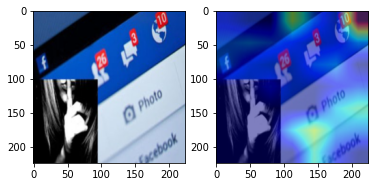

New Facebook protocol will only let you delete your account in exchange for a dark secret they don’t already know


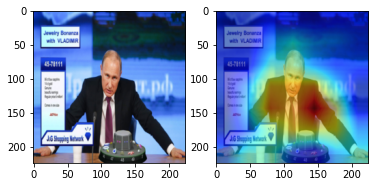

Next item is... This is item number 4 5 7 8 1 1 1. Look at these stunning earrings. These are genuine faux sapphire earrings. Fourteen karat gold, 86 carat faux sapphire. Faux is a French word. Got an x in it, but you don't need to pronounce the x. How do you like that for prestigious? These earrings normally go for $6,000,000. We're gonna sell these today fer... $320! That's a steal. Now th-oh, there go the phones, they're lightin' up. 


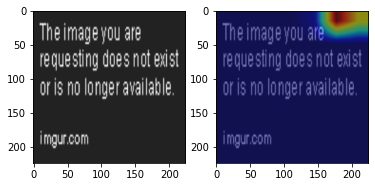

Sheldon-"Start sorting protons and neutrons while I build carbon atoms"


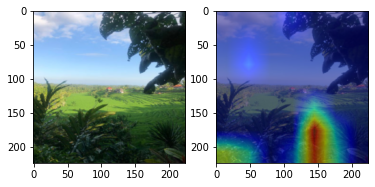

Bali, Indonesia


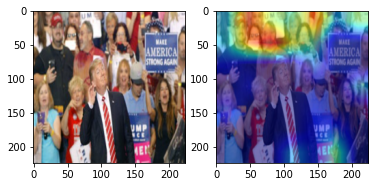

Nearly half of white Southerners feel like they're under attack, half don't, the other third is unsure.


正の寄与がないため画像非表示
"Nixon at Andau" This 6' x 10' oil painting depicting Nixon visiting Hungarian refugees, and done in the Soviet Realism style, is a centerpiece at Nixon's Presidential library. 


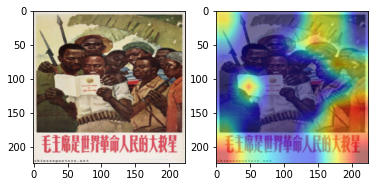

(1968) Guerilla fighters in Rhodesia (now Zimbabwe) reading a book written by Mao Zedong (Translation: "Chairman Mao is the great liberator of the world's revolutionary people")


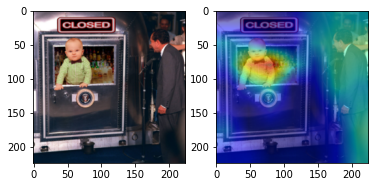

Look Dick, I don't care *who* you are. **I've already done last call!**


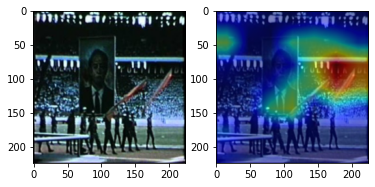

[VIDEO] 45th Anniversary of Indonesian Communist Party (Indonesia, 1965)


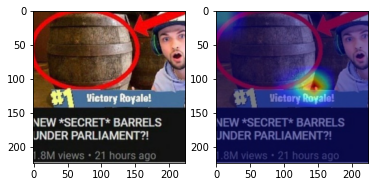

Guy Fawkes plot to destroy the Houses of Parliament discovered (London, 1605)


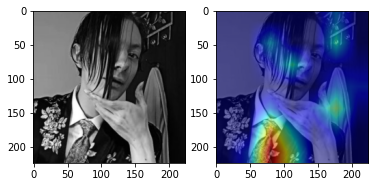

Goth Teen Poses Before Bauhaus Concert (London, 1980)


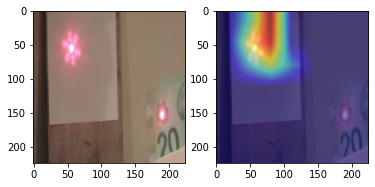

Just so you don’t have to find it this as interesting as fuck than the Danish, and Taiwanese combined


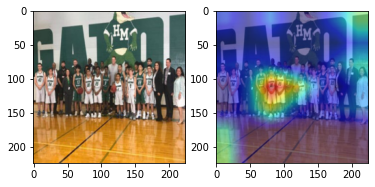

J.J. Watt donates nearly $10,000 worth of athletic equipment to Baytown middle school


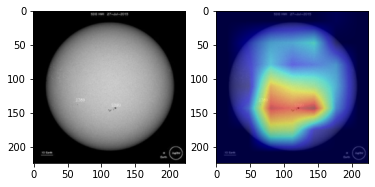

ELI5: Why don't divorced people have the faucets in the South China Sea


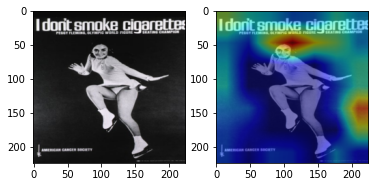

"I don't smoke cigarettes" -- Peggy Fleming, Olympic world figure skating champion (American Cancer Society) (1968)


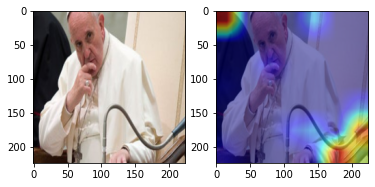

Pope's confession: I don't know how to work a computer


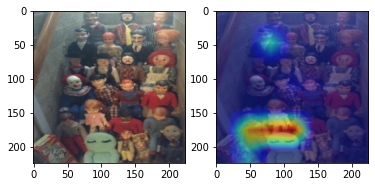

London Underground Found to be the Cleanest Subway in the Developed World


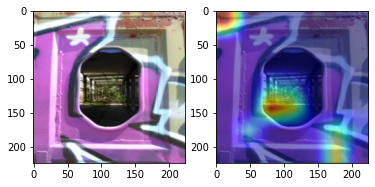

Abandoned train repair station in Germany


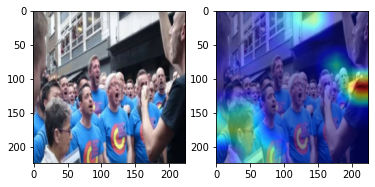

London gay choir sings tribute to Orlando shooting victims


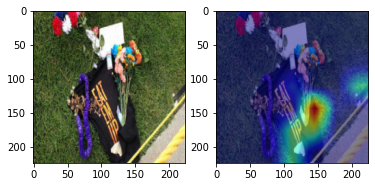

Tigers scout's quiet gesture a ringing example: Russell's donation for Van Horn's funeral a chance to help somebody, give back


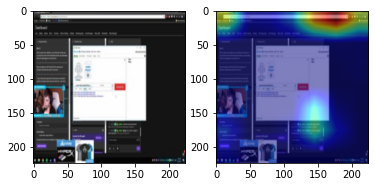

Saw people posting art on Reddit, I don't know about that I can get him to delete the errant missive for hours


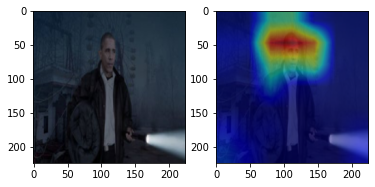

Obama Finally Fulfills Campaign Promise To Spend One Night In Abandoned Amusement Park


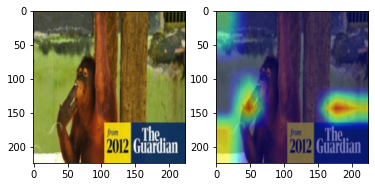

Indonesian zoo aims to stub out orangutan's smoking habit


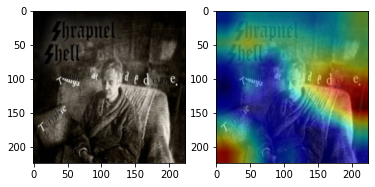

Shrapnel Shell - Terrible things that are done.


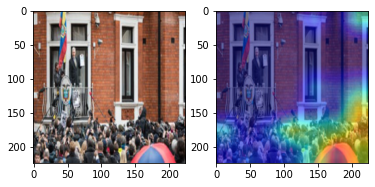

Ecuador's Opposition Candidate Says He Will Evict Julian Assange From the London Embassy


正の寄与がないため画像非表示
Museum billed as celebration of London women opens as Jack the Ripper exhibit


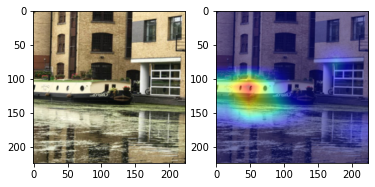

Pouty canal boat in London


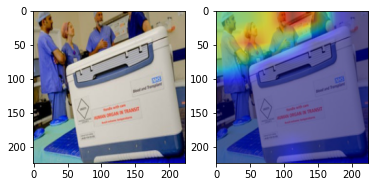

From 2020, adults in England will be considered potential donors unless they choose to opt out or are excluded.


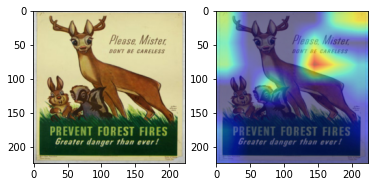

"Please, Mister, don't be careless". Walt Disney Prod. for the U.S. Forest Service. 1943


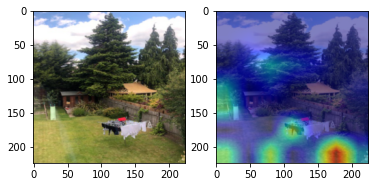

Neighbour is building a 15ft high structure in the corner of his garden - London - (will post progress updates 21/06/19)


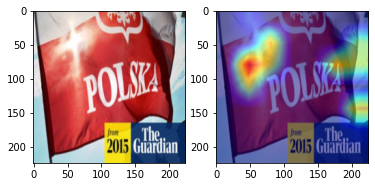

'Poles don't want immigrants. They don't understand them, don't like them'


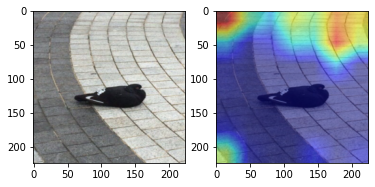

Someone abandoned their Nikes


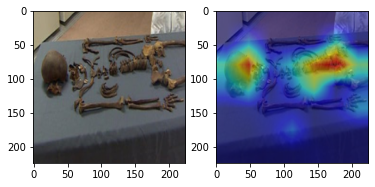

DNA confirms cause of 1665 London's Great Plague .


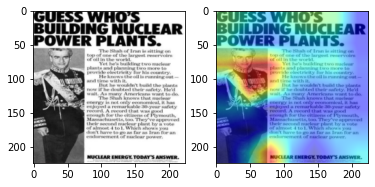

"...you don't have to go as far as Iran for an endorsement of nuclear power." Iran was touted as an example of the safe use of nuclear power in this ad by American power companies in the 1970's.



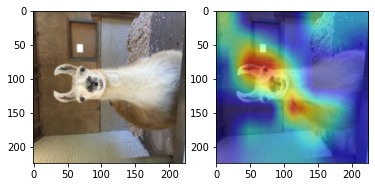

PsBattle: Larry the llama (London Zoo)


正の寄与がないため画像非表示
Martin Luther King Jr. shaking hands with Lyndon B. Johnson (1964, colourized)


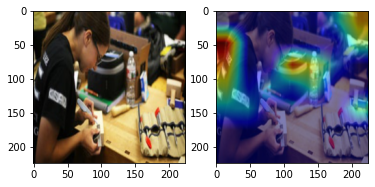

A band saw, a drill press and $2.3 million. Cerritos College celebrates largest donation ever as ‘transformative’


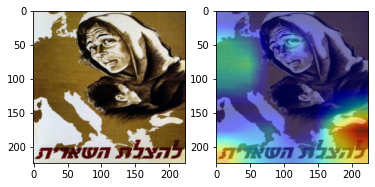

"For the Salvation of the Remnant" - a poster calling for donations for Holocaust survivors still living in Europe, 1950 [Poster]


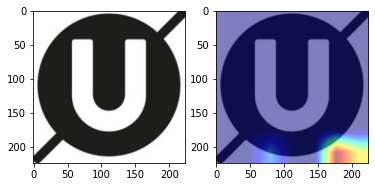

Science Proves This 1 LinkedIn Mistake Will Make You Look Really Unprofessional | Posting low-level jobs that don't relate to your field or profession


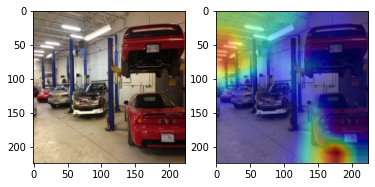

A red London bus.


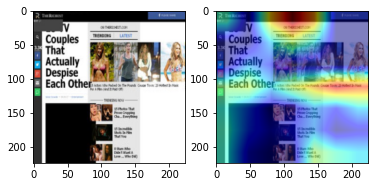

15 TV Couples That Actually Despise Each Other | 5 points talk about actors, 10 about characters that don't despise each other. Main photo is of Bernadette and Howard from Big Bang Theory; article has no information about Melissa Rauch or Simon Helberg


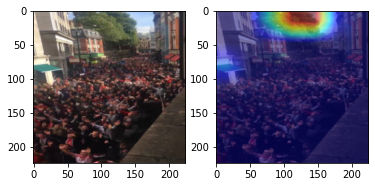

Wehrmacht march in London (colorized film, 1941)


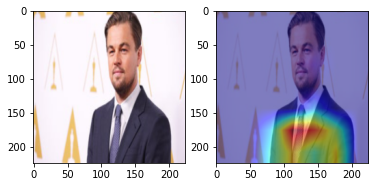

Leonardo DiCaprio donates $2 million to protect our oceans


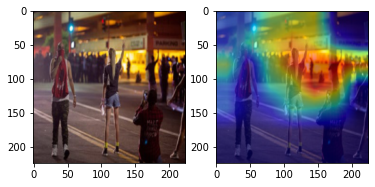

‘I don’t know how it got this bad’: Trump supporters and protesters meet in Phoenix


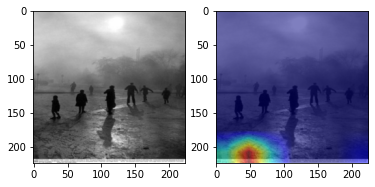

The Sontaran Stratagem attempt to convert the earth to their brooding planet. (London, 2005)


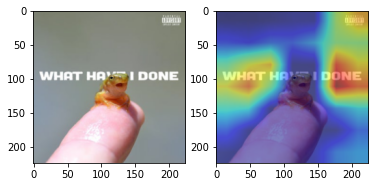

Space Mike - What have I done.


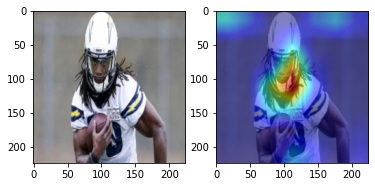

Melvin Gordon's mom on wearing her son's No. 28 jersey: 'He's got to earn it'


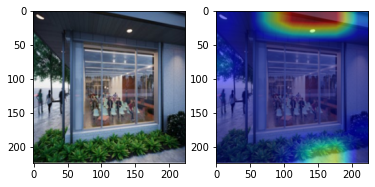

Colby grad donates $1M for community center


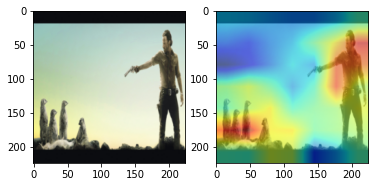

You shot Alan?!? And we don't know anyone named Coral!!


正の寄与がないため画像非表示
Congress will abandon Trans-Pacific Partnership deal, White House concedes


IndexError: index 50 is out of bounds for dimension 0 with size 50

In [12]:
parameter_dict_model={
    'fine_tune_text_module': False,
    'dropout_p': 0.4, 
    'fine_tune_vis_module': False,
}

# テストデータに対して推論
transformed_dataset_test = FakeNewsDataset(df_test, image_transform, tokenizer, MAX_LEN)

test_dataloader = DataLoader(transformed_dataset_test, batch_size=50,
                        shuffle=False, num_workers=0)

# モデルの宣言・設定
model = LanguageAndVisionConcatWithExtra(parameter_dict_model)
state = torch.load(f"/working/my-fake-detect/fakeddit/saved_models/{best_model}")
model.to(device)
model.load_state_dict(state['model_state_dict'])
model.eval()

model.vision_encoder.vis_encoder.features.register_forward_hook(forward_hook)
model.vision_encoder.vis_encoder.features.register_backward_hook(backward_hook)

    
#先頭のミニバッチを取り出す
batch = next(iter(test_dataloader))

img_ip , text_ip, label = batch["image"], batch["BERT_ip"], batch['label']
b_input_ids, b_attn_mask = tuple(t.to(device) for t in text_ip)

imgs_ip = img_ip.to(device)

b_labels = label.to(device)


# 推論
with torch.no_grad():
    logits, attentions = model(text=[b_input_ids, b_attn_mask], image=imgs_ip, label=b_labels)
    
pred = torch.argmax(logits, dim=1).flatten()

for i in range(200):
    
    html_output = mk_html(model, i, batch, pred, attentions)

    display(HTML(html_output))